# Exploration of Quora dataset

In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background") # comment out if using light Jupyter theme

dtypes = {"qid": str, "question_text": str, "target": int}
train = pd.read_csv("../data/train.csv", dtype=dtypes)
test = pd.read_csv("../data/test.csv", dtype=dtypes)

## 1. A first glance

In [2]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [11]:
print("There are {} questions in train and {} in test".format(train.shape[0], test.shape[0]))

There are 1306122 questions in train and 56370 in test


In [10]:
print("Target value is binary (values: {})".format(set(train["target"].unique())))

Target value is binary (values: {0, 1})


In [12]:
print("Number of toxic questions in training data is {} (proportion: {}).".format(train["target"].sum(), train["target"].mean()))

Number of toxic questions in training data is 80810 (proportion: 0.06187017751787352).


## 2. A closer look at the questions

### 2.1 Question length (characters)

In [21]:
train["text_length"] = train["question_text"].str.len()
train["text_length"].describe()

count    1.306122e+06
mean     7.067884e+01
std      3.878428e+01
min      1.000000e+00
25%      4.500000e+01
50%      6.000000e+01
75%      8.500000e+01
max      1.017000e+03
Name: text_length, dtype: float64

Most questions are relatively short, i.e., less than 100 characters. There are some exceptions, however, with a maximum of more than a thousand. Let's see how many characters we should consider.

In [24]:
for length in [100, 150, 200, 250, 300, 350, 500]:
    num = np.sum(train["text_length"] > length)
    print("There are {} questions ({}%) with more than {} characters."
          .format(num, np.round(num / len(train) * 100, 2), length))

There are 219931 questions (16.84%) with more than 100 characters.
There are 56910 questions (4.36%) with more than 150 characters.
There are 20393 questions (1.56%) with more than 200 characters.
There are 115 questions (0.01%) with more than 250 characters.
There are 11 questions (0.0%) with more than 300 characters.
There are 4 questions (0.0%) with more than 350 characters.
There are 4 questions (0.0%) with more than 500 characters.


The number of questions with more than 250 characters is already small and with more than 300 negligible. We can cut the questions at 300 or even just remove them. Would there be a difference between the length of toxic and sincere questions?

In [47]:
def split_on_target(data):
    toxic = data[data["target"] == 1]
    sincere = data[data["target"] == 0]
    return sincere, toxic

sincere, toxic = split_on_target(train)

C:\Users\s100385\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\s100385\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


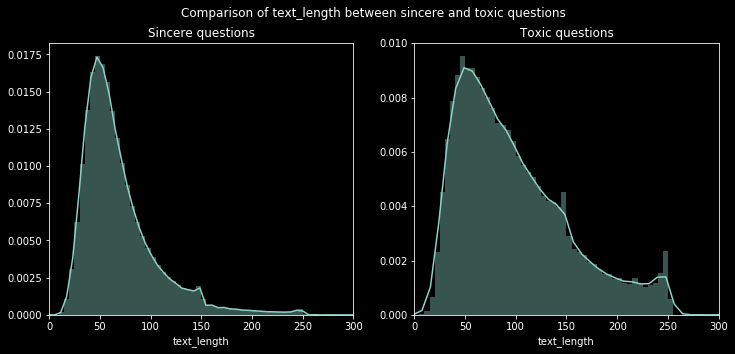

In [56]:
def plot_density_plots(sincere_data, toxic_data, column, xlim=(0, 300), bin_size=5):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0] = sns.distplot(sincere_data[column], ax=axes[0], bins=np.arange(xlim[0], xlim[1], bin_size))
    axes[0].set_title("Sincere questions")
    axes[1] = sns.distplot(toxic_data[column], ax=axes[1], bins=np.arange(xlim[0], xlim[1], bin_size))
    axes[1].set_title("Toxic questions")
    if xlim is not None:
        for ax in axes:
            ax.set_xlim(xlim[0], xlim[1])
    plt.suptitle("Comparison of {} between sincere and toxic questions".format(column))
    plt.show()

plot_density_plots(sincere, toxic, "text_length")

Toxic questions seem to have a higher chance of having somewhat more characters, although the medians seem to be more or less the same. The numbers confirm:

In [57]:
pd.concat([sincere["text_length"].describe(), toxic["text_length"].describe()], axis=1)

,text_length,text_length
count,1.225312e+06,80810.000000
mean,6.887276e+01,98.064163
std,3.674032e+01,55.186227
min,5.000000e+00,1.000000
25%,4.400000e+01,55.000000
50%,5.900000e+01,86.000000
75%,8.300000e+01,130.000000
max,7.520000e+02,1017.000000


### 2.2 Question length (words)
A similar analysis can be done based on the number of _words_ per question, rather than the number of characters. To do this properly, we should probably first remove symbols and punctuation, but let's take a quick look.

In [58]:
train["words"] = train["question_text"].apply(lambda x: len(x.split(" ")))
sincere, toxic = split_on_target(train)

C:\Users\s100385\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\s100385\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


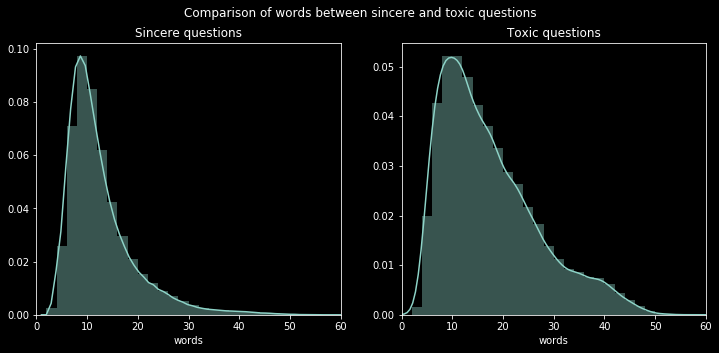

In [59]:
plot_density_plots(sincere, toxic, "words", xlim=(0, 60), bin_size=2)

The same conclusion seems to hold for the number of words. It is, thus, useful to include the question size as a feature in our models. Also, it seems that there are not many questions with more than 50 or 60 words:

In [62]:
for n in [50, 55, 60]:
    print("{} questions with more than {} words.".format(np.sum(train["words"] > n), n))

539 questions with more than 50 words.
37 questions with more than 55 words.
5 questions with more than 60 words.
